In [1]:
import os
import shutil
from time import sleep
from pprint import pprint

import tensorflow as tf
import numpy as np

from batchflow.models.tf import EfficientNetB0

from batchflow import Pipeline, B, V, C, D, ImagesBatch
from batchflow.opensets import CIFAR10
from batchflow.research import Option, Research, Results

%env CUDA_VISIBLE_DEVICES='6,7'

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

env: CUDA_VISIBLE_DEVICES='6,7'


In [2]:
cifar = CIFAR10(batch_class=ImagesBatch, bar=True)


100%|██████████| 6/6 [00:07<00:00,  1.72s/it]


In [3]:
new_res = EfficientNetB0.resolution
im_shape = (new_res, new_res, 3)

model_config = {
    'inputs/images/shape': B('image_shape'), #im_shape,
    'inputs/labels/classes': D('num_classes'),
    'initial_block/inputs': 'images',
    'loss': 'ce'
}

train_ppl = (cifar.train.p
#                   .resize((new_res, new_res))
                  .init_variable('loss_history', default=[])
                  .init_model('dynamic', EfficientNetB0, 'mnist_model', config=model_config)
                  .to_array()
                  .train_model('mnist_model', fetches='loss', images=B('images'), labels=B('labels'), 
                               save_to=V('loss_history', mode='a'))
                  .run_later(64, shuffle=True, n_epochs=1, drop_last=True))

In [4]:
train_ppl = train_ppl.run(bar=True)

  0%|          | 0/781 [00:00<?, ?it/s]

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


100%|██████████| 781/781 [08:55<00:00,  1.60it/s]


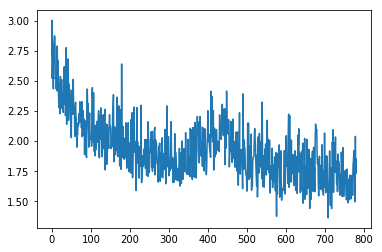

In [7]:
from matplotlib import pyplot as plt
plt.plot(train_ppl.get_variable('loss_history'))

In [29]:
test_pipeline = (cifar.test.p
                .import_model('mnist_model', train_ppl)
                .init_variable('predictions') 
                .init_variable('metrics') 
                .to_array()
                .predict_model('mnist_model', fetches='predictions', 
                               images=B('images'),
                               save_to=V('predictions'))
                .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                fmt='logits', axis=-1, save_to=V('metrics'))
                .run(64, shuffle=True, n_epochs=1, drop_last=False, bar=True)
)

100%|██████████| 157/157 [00:15<00:00, 10.01it/s]


In [30]:
metrics = test_pipeline.get_variable('metrics')

metrics.evaluate('accuracy')

0.1875

In [ ]:
boom

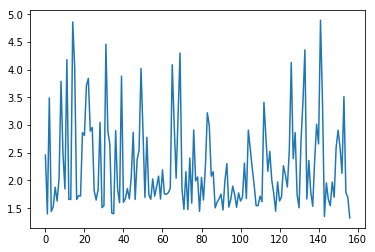

In [12]:
plt.plot(test_pipeline.get_variable('loss'))

In [ ]:
model_config = {
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'initial_block/inputs': 'images',
    
    'common/width_factor': C('width_factor'),
    'common/depth_factor': C('depth_factor'),
    
    'loss': 'crossentropy',
    'optimizer': 'Adam', 
}

train_ppl = (dataset.train.p
                  .init_variable('loss') 
                  .init_model('dynamic', ScalableModel, 'mnist_model', config=model_config)
                  .to_array()
                  .train_model('mnist_model', fetches='loss',
                               images=B('images'), labels=B('labels'), 
                               save_to=V('loss'))
             .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

test_ppl = (dataset.test.p
                 .import_model('mnist_model', C('import_from'))
                 .init_variable('loss')
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .to_array()
                 .predict_model('mnist_model', fetches=['loss', 'predictions'],
                                images=B('images'), labels=B('labels'), 
                                save_to=[V('loss'), V('predictions')])
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                 fmt='logits', axis=-1, save_to=V('metrics'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=1))


In [ ]:
op1 = Option('width_factor', [1, 1.5, 2])
op2 = Option('depth_factor', [1, 2])
grid = op1 * op2

list(grid.gen_configs())

In [ ]:
research = (Research()
            .add_pipeline(train_ppl, variables='loss', name='train')
            .add_pipeline(test_ppl, variables='loss', name='test', execute=10,
                          run=True, import_from='train')
            .get_metrics(pipeline='test', metrics_var='metrics', metrics_name='accuracy',
                         returns='accuracy', execute=10)
            .add_grid(grid))

In [ ]:
!rm -r scalable_research

In [ ]:
NUM_REPEATS = 3
NUM_ITERS = 100
research_name = 'scalable_research'

research.run(n_reps=NUM_REPEATS, n_iters=NUM_ITERS, name=research_name, bar=True)


In [ ]:
res = research.load_results(use_alias=True)
res.info()

In [ ]:
from batchflow.utils import plot_results_by_config

plot_results_by_config(res, (('train', 'loss'), ('test', 'loss'), ('test_metrics', 'accuracy')))

In [ ]:
model_config = {
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'initial_block/inputs': 'images',
    
    'common/width_factor': 3,
    'common/depth_factor': 2,
    
    'loss': 'crossentropy',
    'optimizer': 'Adam', #('Momentum', {'use_nesterov': True, 'learning_rate': 0.01, 'momentum': 0.5}),
#     'output': ['proba']
}

train_template = (Pipeline()
                  .init_variable('loss_history', default=[])
                  .init_model('dynamic', ScalableModel, 'mnist_model', config=model_config)
                  .to_array()
                  .train_model('mnist_model', fetches='loss', images=B('images'), labels=B('labels'), 
                               save_to=V('loss_history', mode='a'))
                  .run_later(64, shuffle=True, n_epochs=1, drop_last=True, bar=True))

In [ ]:
train_pipeline = (train_template << dataset.train).run()

plt.plot(train_pipeline.get_variable('loss_history'))
